# Deep Learning for Deciphering Traffic Signs
## Pre-trained Model Notebook
_________________________________________________________________________________________________________________________________________________________________________________

##### Contributors:
 Victor Floriano, Yifan Fan, Jose Salerno

## Problem Statement & Motivation
As the world advances towards autonomous vehicles, our team has observed the remarkable efforts of large car manufacturers, who are working with data scientists to develop fully autonomous cars. Our team is excited to contribute to the development of this technology by creating a neural network model that will be able to classify different traffic signs. Our ultimate goal is to assist car makers in overcoming the challenges they may face in implementing neural network models that effectively read traffic signs and further their efforts toward a fully autonomous car or assisted driving. We believe autonomous driving to be an important problem to solve due to the great economic benefits it can generate for car manufacturers and the improvement of general driving safety.

## Data Preparation
 We've selected the German Traffic Sign Recognition Benchmark (GTSRB) as our primary dataset. It's renowned for its complexity, featuring over 50,000 images across more than 40 classes of traffic signs. The GTSRB is publicly accessible through two resources. To efficiently manage the extensive and complex GTSRB dataset, our strategy integrates preprocessing for uniformity, data augmentation for robustness, and batch processing for computational efficiency. We'll employ distributed computing to parallelize operations, enhancing processing speed, and use stratified sampling for quick experimentation without compromising representativeness.



---





# Pre-Trained Models
- We implemented the pre-trained model Resnet18, the reason why we choose Resnet18 was because of its strong performance in image classification. ResNet-18 originally uses an input size of 256x256 pixels, but it can automatically resize images to meet its input requirements. This allowed us to benefit from the models features on large dataset, enabling us to implement transfer learning in our particular task of classifying traffic signs. Finally, we adjusted the output layer to fit our number of classes when it came to classfication. 

 
________________________________________________________________________________________________________________________________________________

Results: 

- Validation Accuracy = 99.66%

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

In [2]:
enable_wandb = True
use_gpu = True
gpu_available = torch.cuda.is_available()
gpu_available

True

In [3]:
#Loading images - from Datacamp CNN course (cloud example)
from torchvision.datasets import ImageFolder
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((56,56))
])

dataset_train = ImageFolder(
    'Train',
    transform = train_transforms
)

In [4]:
train_dataset, val_dataset = random_split(dataset_train, [0.8, 0.2])

torch.Size([1, 3, 56, 56])
Label: tensor([13])
tensor([13])


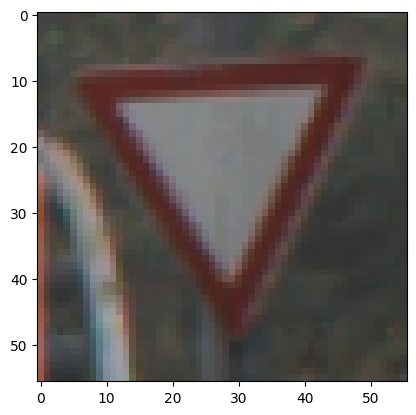

In [8]:
from torch.utils.data import DataLoader

#Trying to display images
dataloader_train = DataLoader(
    dataset_train,
    shuffle=True,
    batch_size=1,
)

image, label = next(iter(dataloader_train))
print(image.shape)
print('Label:',label)
print(label)

image = image.squeeze().permute(1,2,0)

plt.imshow(image)
plt.show()

In [9]:
num_samples = 39219
num_images_per_class = {
    0: 210, 1: 2220, 10: 2010, 11: 1320, 12: 2100, 13: 2160, 14: 780, 15: 630,
    16: 420, 17: 1110, 18: 1200, 19: 210, 2: 2250, 20: 360, 21: 330, 22: 390,
    23: 510, 24: 270, 25: 1500, 26: 600, 27: 240, 28: 540, 29: 270, 3: 1410,
    30: 450, 31: 780, 32: 240, 33: 689, 34: 420, 35: 1200, 36: 390, 37: 210,
    38: 2070, 39: 300, 4: 1980, 40: 360, 41: 240, 42: 240, 5: 1860, 6: 420,
    7: 1440, 8: 1410, 9: 1470
}

class_weights = {}
for class_id, num_images in num_images_per_class.items():
    weight_for_class = num_samples / (num_images * 2)
    class_weights[class_id] = weight_for_class

print("Class Weights:")
for class_id, weight in class_weights.items():
    print(f"Class {class_id}: {weight:.4f}")

Class Weights:
Class 0: 93.3786
Class 1: 8.8331
Class 10: 9.7560
Class 11: 14.8557
Class 12: 9.3379
Class 13: 9.0785
Class 14: 25.1404
Class 15: 31.1262
Class 16: 46.6893
Class 17: 17.6662
Class 18: 16.3412
Class 19: 93.3786
Class 2: 8.7153
Class 20: 54.4708
Class 21: 59.4227
Class 22: 50.2808
Class 23: 38.4500
Class 24: 72.6278
Class 25: 13.0730
Class 26: 32.6825
Class 27: 81.7062
Class 28: 36.3139
Class 29: 72.6278
Class 3: 13.9074
Class 30: 43.5767
Class 31: 25.1404
Class 32: 81.7062
Class 33: 28.4608
Class 34: 46.6893
Class 35: 16.3412
Class 36: 50.2808
Class 37: 93.3786
Class 38: 9.4732
Class 39: 65.3650
Class 4: 9.9038
Class 40: 54.4708
Class 41: 81.7062
Class 42: 81.7062
Class 5: 10.5427
Class 6: 46.6893
Class 7: 13.6177
Class 8: 13.9074
Class 9: 13.3398


In [10]:
class_weights = torch.tensor([
    93.3786, 8.8331, 9.7560, 14.8557, 9.3379, 9.0785, 25.1404, 31.1262, 46.6893, 17.6662,
    16.3412, 93.3786, 8.7153, 54.4708, 59.4227, 50.2808, 38.4500, 72.6278, 13.0730, 32.6825,
    81.7062, 36.3139, 72.6278, 13.9074, 43.5767, 25.1404, 81.7062, 28.4608, 46.6893, 16.3412,
    50.2808, 93.3786, 9.4732, 65.3650, 9.9038, 54.4708, 81.7062, 81.7062, 10.5427, 46.6893,
    13.6177, 13.9074, 13.3398
])

criterion = nn.BCEWithLogitsLoss(weight= class_weights)

In [11]:
# Hyperparameters

configs = {
    "experiment_name": "Pre-trained Model",
    "data_augmentation":True,

    # Data
    "img_dimensions" : (3,56,56),
    "batch_size" : 350,
    "num_classes" : 43,

    # CNN
    "filter_sizes" : [4, 16, 32, 64],
    "kernel_size" : 5,
    "stride": 2,
    "padding":2,

    #Optimzation
    "learning_rate" : 0.0001,
    "epochs" : 25,
    "weight_decay" : 0.00001,
    "epochs" : 35
}


In [12]:
train_loader = DataLoader(dataset=train_dataset, batch_size = configs['batch_size'], shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size = configs['batch_size'], shuffle=False)

In [13]:
if configs["data_augmentation"]:
  transform = transforms.Compose([
      transforms.RandomHorizontalFlip(0.5),
      transforms.Resize(56),
      transforms.RandomRotation(45),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
else:
  transform = transforms.Compose([
      transforms.Resize(56),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

In [15]:
import torchmetrics

In [16]:
from torchvision.models import resnet18, ResNet18_Weights

# Load the pre-trained ResNet-18 model with specified weights
weights = ResNet18_Weights.IMAGENET1K_V1  # This is equivalent to the previously used pretrained=True
model = resnet18(weights=weights)

In [17]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─BasicBlock: 2-1                   --
│    │    └─Conv2d: 3-1                  36,864
│    │    └─BatchNorm2d: 3-2             128
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  36,864
│    │    └─BatchNorm2d: 3-5             128
│    └─BasicBlock: 2-2                   --
│    │    └─Conv2d: 3-6                  36,864
│    │    └─BatchNorm2d: 3-7             128
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  36,864
│    │    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
│    └─BasicBlock: 2-3                   --
│    │    └─Conv2d: 3-11                 73,728

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = configs['learning_rate'], weight_decay = configs['weight_decay'])

In [20]:
def get_accuracy(dataloader, model):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    acc = torchmetrics.Accuracy(task="MULTICLASS", num_classes=configs['num_classes']).to(device)

    model.eval()
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, axis=1)
            acc.update(preds, labels)

    accuracy = acc.compute()
    model.train()
    return accuracy

In [21]:
def get_loss(loader):
    model.eval()
    loss = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            if gpu_available and use_gpu:
                images = images.cuda()
                labels = labels.cuda()
            outputs = model(images)
            loss = loss + criterion(outputs, labels)
    return loss / len(loader.dataset)

In [22]:
class EarlyStopper:
    def __init__(self, patience=1):
        self.patience = patience
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
            torch.save(model.state_dict(), "./best_model.pt")
        elif validation_loss > self.min_validation_loss:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

early_stopper = EarlyStopper(patience=3)

In [27]:
unique_labels = set()
for _, labels in train_loader:
    unique_labels.update(labels.numpy())
print("Unique labels in training data:", unique_labels)


Unique labels in training data: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42}


In [35]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 43)  # Ensure this matches the number of classes

In [33]:
from torchmetrics import Accuracy

# Assuming device is defined as 'cuda' if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
accuracy_metric = Accuracy(num_classes=43, average='macro', task='multiclass').to(device)


In [39]:
for epoch in range(configs['epochs']):
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        if gpu_available and use_gpu:
            images = images.to(device)
            labels = labels.to(device)
            model = model.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Both preds and labels need to be on the same device
        preds = preds.to(device)
        labels = labels.to(device)  # Redundant if already on GPU, but ensures consistency

        # Update metric
        accuracy_metric.update(preds, labels)
        
        if i % 100 == 0:
            print("Epoch", epoch + 1, "batch", i + 1, ". Training Loss: ", loss.item())
    train_acc = accuracy_metric.compute()
    print(f'Epoch [{epoch + 1}/{configs["epochs"]}], Train Accuracy: {train_acc.item():.4f}')
    accuracy_metric.reset()
    # Assuming get_accuracy and get_loss are updated to handle device transfers
    val_acc = get_accuracy(val_loader, model)
    validation_loss = get_loss(val_loader)

    print(f'Validation Accuracy: {val_acc.item():.4f}')


Epoch 1 batch 1 . Training Loss:  0.060595255345106125
Epoch [1/35], Train Accuracy: 0.9944
Validation Accuracy: 0.9912
Epoch 2 batch 1 . Training Loss:  0.01945233717560768
Epoch [2/35], Train Accuracy: 0.9994
Validation Accuracy: 0.9930
Epoch 3 batch 1 . Training Loss:  0.01179986260831356
Epoch [3/35], Train Accuracy: 0.9999
Validation Accuracy: 0.9944
Epoch 4 batch 1 . Training Loss:  0.006606792099773884
Epoch [4/35], Train Accuracy: 0.9999
Validation Accuracy: 0.9949
Epoch 5 batch 1 . Training Loss:  0.005559645593166351
Epoch [5/35], Train Accuracy: 0.9999
Validation Accuracy: 0.9955
Epoch 6 batch 1 . Training Loss:  0.004781764466315508
Epoch [6/35], Train Accuracy: 1.0000
Validation Accuracy: 0.9958
Epoch 7 batch 1 . Training Loss:  0.003677635220810771
Epoch [7/35], Train Accuracy: 1.0000
Validation Accuracy: 0.9958
Epoch 8 batch 1 . Training Loss:  0.002481186995282769
Epoch [8/35], Train Accuracy: 1.0000
Validation Accuracy: 0.9959
Epoch 9 batch 1 . Training Loss:  0.003741

____

## Sources
- Generative AI was utilized for Debugging, code improvement, sentence structure and grammar.
- Transfer Learning Notebook 